# Problem 1: GMM

In [4]:
library(gmm)
library(tseries)

#### (a) How would you identify the lag q? Identify the lag q.

[1] 3


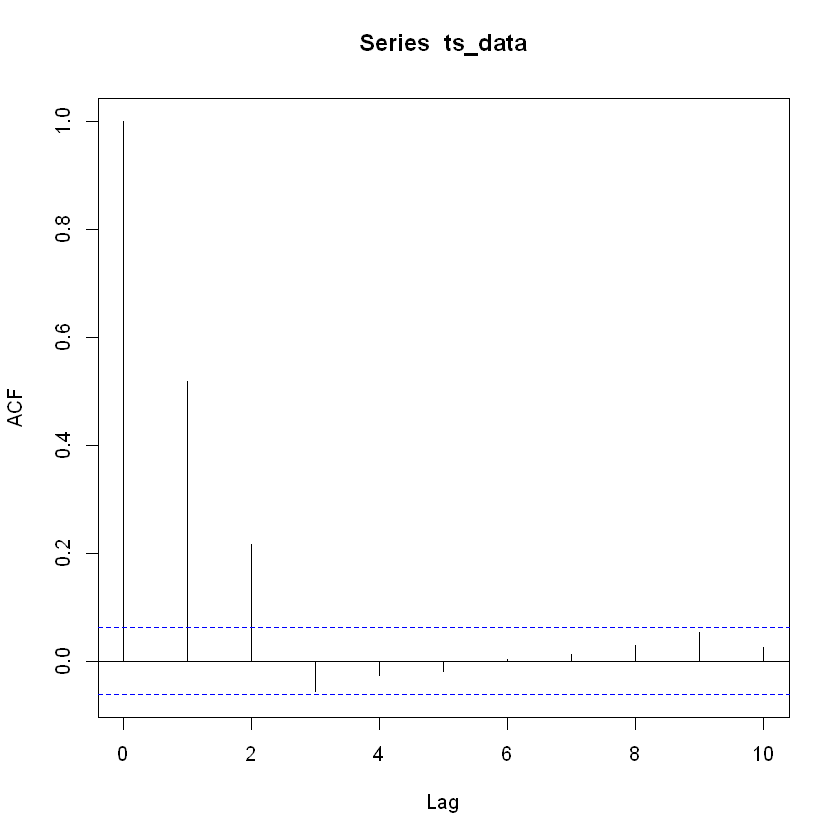

In [5]:
# Load the data
data <- read.csv("hw_data.csv")

# Create a time series object
ts_data <- ts(data$x)

# Compute autocorrelation function
acf_values <- acf(ts_data, lag.max = 10)

# Find the first lag where autocorrelation is not significant
lag_q <- which(acf_values$acf < 0.05)[1] - 1
print(lag_q)

We begin with loading the data and converting them to a time series object. Then the autocorrelation function is performed and the resulting lags plotted. We can see on the graph that already fourth lag became insignificant. Assuming that this function considers the first lag to be in time 0, which is technically not a lag, we found out there are 2 lags present in our data. Therefore, we are dealing with AR(2) model.


#### (b) Derive the moment conditions function

In [6]:
ma2_moments = function(parm, data = NULL) {
  mu = parm[1]
  theta1 = parm[2]
  theta2 = parm[3]
  sigma2 = parm[4] 
  
  
  m1 = mu
  m2 = mu^2 + sigma2 * (1 + theta1^2 + theta2^2)
  m3 = mu^2 + sigma2 * (theta1 + theta2*theta1)
  m4 = mu^2 + sigma2 * theta2   
  m5 = mu^2
  # moment conditions:
  t(t(data) - c(m1, m2, m3, m4, m5))
}

Since we need to estimate 4 parameters (mu, theta1, theta2, sigma^2) for the AR(2) model and we want to have an over-identified solution using more moment conditions than estimating coeffitients, we need to calculate the first 5 moments ($E[Y_t],E[Y_t^2], E[Y_tY_{t-1}], E[Y_tY_{t-2}], E[Y_tY_{t-3}]$.

$Y_t=\mu+\epsilon_t+\theta_1\epsilon_{t-1}+\theta_2\epsilon_{t-2}$


Similarly for $Y_{t-1},Y_{t-2},Y_{t-3}$

$Y_{t-1}=\mu+\epsilon_{t-1}+\theta_1\epsilon_{t-2}+\theta_2\epsilon_{t-3}$ 

$Y_{t-2}=\mu+\epsilon_{t-2}+\theta_1\epsilon_{t-3}+\theta_2\epsilon_{t-4}$

$Y_{t-3}=\mu+\epsilon_{t-3}+\theta_1\epsilon_{t-4}+\theta_2\epsilon_{t-5}$

It should hold that $\epsilon=\sigma$

From that, we derived following moments.

$$
\begin{aligned}
E[Y_t]&=\mu\\
E[Y_t^2]&=\mu^2+\sigma^2(1+\theta_1^2+\theta_2^2)\\
E[Y_tY_{t-1}]&=\mu^2+\sigma^2(\theta_1+\theta_1 \theta_2)\\
E[Y_tY_{t-2}]&=\mu^2+\sigma^2\theta_2\\
E[Y_tY_{t-3}]&=\mu^2\\
\end{aligned}
$$

#### (c) Estimate the model using ’gmm’ with an identity weighting matrix. Provide the output and interpret the coefficient significance and the J-test statistic.

In [7]:
N = length(ts_data)

# Data matrix
ma2_data = cbind(ts_data[4:N],
                 ts_data[4:N]^2,
                 ts_data[4:N]*ts_data[3:(N-1)],
                 ts_data[4:N]*ts_data[2:(N-2)],
                 ts_data[4:N]*ts_data[1:(N-3)])

# Moments
ma2_mom = ma2_moments(c(0, 0.5, 0.5, 1), data = ma2_data)

# Start values
start_vals = c(0, 0.5, 0.5, 1)
names(start_vals) = c("mu", "theta1", "theta2", "sigma2")


Furthermore, the data modification according to the defined formula needs to be undertaken for moment vector calculation in the function above. We also calculated the moments and set the initial values for optimization with respective labels in this part of code.

In [13]:
ma2_gmm_identity = gmm(ma2_moments, ma2_data, t0=start_vals, wmatrix="ident", 
            optfct = "nlminb", vcov = "HAC", kernel = "Truncated")

summary(ma2_gmm_identity)
print(specTest(ma2_gmm_identity))


Call:
gmm(g = ma2_moments, x = ma2_data, t0 = start_vals, wmatrix = "ident", 
    vcov = "HAC", kernel = "Truncated", optfct = "nlminb")


Method:  One step GMM with W = identity 

Kernel:  Truncated

Coefficients:
         Estimate     Std. Error   t value      Pr(>|t|)   
mu        2.4064e-02   7.0152e-02   3.4302e-01   7.3158e-01
theta1    5.5850e-01   3.4779e-02   1.6059e+01   4.9762e-58
theta2    3.0271e-01   6.4055e-02   4.7257e+00   2.2927e-06
sigma^2   1.0196e+00   4.6682e-02   2.1842e+01  9.2142e-106

J-Test: degrees of freedom is 1 
                J-test    P-value 
Test E(g)=0:    6.278246  0.012223

#############
Information related to the numerical optimization
Convergence code =  0 
Function eval. =  19 
Gradian eval. =  68 
Message:  relative convergence (4) 


 ##  J-Test: degrees of freedom is 1  ## 

                J-test    P-value 
Test E(g)=0:    6.278246  0.012223



All coefficients except mu(mean) are significant(at 0.1% level). We can observe that the standard error compared to the mu estimate seems too high (mu = 0.02, std. error = 0.07), std. error is 3.5 times bigger! The rest seems quite fine. On the other hand, the J-test shows that the model is misspecified (we can reject H0 at 5% level, that the value of the objective function is different from zero). Although it does not reveal the cause of the misspecification, it is most probable that it is due to choosing the wrong matrix e.g., the identity matrix. For cases with more moment conditions than parameters (over-identification), using a two-step method with an optimal matrix is appropriate instead of the one-step method with an identity matrix. 

#### (d) Estimate the model using ’gmm’ with an optimal weighting matrix. Provide the output and interpret the coefficient significance and the J-test statistic.

In [14]:
ma2_gmm_optimal = gmm(ma2_moments, ma2_data, t0=start_vals, wmatrix="optimal", 
            optfct = "nlminb", vcov = "HAC", kernel = "Truncated")

summary(ma2_gmm_optimal)
print(specTest(ma2_gmm_optimal))


Call:
gmm(g = ma2_moments, x = ma2_data, t0 = start_vals, wmatrix = "optimal", 
    vcov = "HAC", kernel = "Truncated", optfct = "nlminb")


Method:  twoStep 

Kernel:  Truncated(with bw =  1.2454 )

Coefficients:
         Estimate     Std. Error   t value      Pr(>|t|)   
mu        2.4968e-02   7.0143e-02   3.5596e-01   7.2187e-01
theta1    5.7533e-01   3.2926e-02   1.7474e+01   2.2694e-68
theta2    3.7616e-01   3.9341e-02   9.5616e+00   1.1593e-21
sigma^2   9.9506e-01   4.5840e-02   2.1707e+01  1.7585e-104

J-Test: degrees of freedom is 1 
                J-test   P-value
Test E(g)=0:    1.72171  0.18947

Initial values of the coefficients
        mu     theta1     theta2    sigma^2 
0.02406389 0.55849963 0.30270706 1.01963595 

#############
Information related to the numerical optimization
Convergence code =  0 
Function eval. =  13 
Gradian eval. =  56 
Message:  relative convergence (4) 


 ##  J-Test: degrees of freedom is 1  ## 

                J-test   P-value
Test E(g)=0:    1.72171  0.18947



Surprisingly, the results of coefficients, std. errors and p-values are quite similar to the previous model specification. The only significant difference is that the J-test is far smaller and does not suggest any misspecification of the model (cannot reject H0 that the model is misspecified). This is likely due to correctly choosing the two-stage method with the optimal matrix, as mentioned in 1.C. 

#### (e) Compare the results from c) and d).

In [15]:
# Compare results
cat("Results from (c):", "\n")
print(ma2_gmm_identity)

cat("\nResults from (d):", "\n")
print(ma2_gmm_optimal)


Results from (c): 
Method
 One step GMM with W = identity 

Objective function value:  0.00646133 

      mu    theta1    theta2   sigma^2  
0.024064  0.558500  0.302707  1.019636  

Convergence code =  0 

Results from (d): 
Method
 twoStep 

Objective function value:  0.001726892 

      mu    theta1    theta2   sigma^2  
0.024968  0.575335  0.376164  0.995062  

Convergence code =  0 


In summary, both model specifications provided similar results, but the two-step method with optimal matrix seems specified correctly, while the one-step method does not(according to J-statistics). Although this is expected (explained in section  1.C), the fact that the results are similar is quite surprising. 

# Problem 2: Delta method

Creating variables $X_1$ and $X_2$:


$X_1 = 0.2V_1 + 0.7V_2 + 0.3V_3$

$X_2 = 4V_2 − 3V_3$

$V_1 ∼ N(0,1), V_2 ∼ χ^2(3), V_3 ∼ U[1,2]$

The linear model is defined as:

$Y =β_0 +β_1X_1 +β_2X_2 +ε$

Generate 500 observations. The true values of betas are $β_0 = 2, β_1 = 4, β_2 = 3$, and
ε ∼ N (0, 1). Let us assume, that we are interested in quantity $Φ$: 

$Φ=ln(β_0 +β_1^2)−\beta_1^{1/2}$



In [ ]:
set.seed(123)
n=500
v1 = rnorm(n, mean = 0, sd = 1)
v2 = rchisq(n,3)
v3  = runif(n, 1, 2)
epsilon = rnorm(n, mean = 0, sd = 1)

x1 = 0.2 * v1 + 0.7 * v2 + 0.3 * v3
x2 = 4 * v2 - 3 * v3 
b0 = 2
b1 = 4
b2 = 3

y = 2 + 4*x1 + 3*x2 + epsilon
frame <- data.frame(y, x1, x2)

m1 <- lm(y~x1+x2)
summary(m1)

#### calculation true value of $Φ$:

In [ ]:
# Φ= log(b0+b1^2)-(b1^(1/2))

phi_true = log(b0+b1^2)-(b1^(1/2))
sprintf("true value of phi equals: %.7f", phi_true)

#### estimation of $Φ$:

In [ ]:
bet0=coef(m1)[1]
bet1=coef(m1)[2]
phi_m1=log(bet0+bet1^2) - bet1^(1/2)
sprintf("phi equals: %.7f", phi_m1)

#### variance estimation of $Φ$:
###### a) delta method by hand

In [ ]:
#Derivation of phi with respect to beta0: beta0 = 1/(beta0 + beta1^2)
#Derivation of phi with respect to beta1: beta1 = 2beta1/(beta0 + beta1^2) - (1/2)*beta1^(-1/2)

par.deriv0=1/(bet0+bet1^2)
par.deriv1=((2*bet1)/(bet0+bet1^2))- (1/2)*bet1^(-1/2)
grad=c(par.deriv0,par.deriv1)

# using delta method, variance of phi=t(grad)*vcov(x)*grad
v_x=vcov(m1)[-3,-3] #we do not need full covariance matrix only beta0 and beta1 –> drop beta2
v_x

vG= t(grad)%*% v_x %*% grad

sprintf("Approximate variance for phi calculated using OLS output: %.7f",vG) 



###### b) delta method using "deltamethod" function

In [ ]:
library(msm)

a <- vcov(m1)[-3, -3]
b <- coef(m1)[1:2] #coef. of intercept and x1

se.z.dm <- deltamethod(~(log(x1 + x2^2))- (x2^(1/2)), b, a)
sprintf("Variance using deltamethod function: %.7f",se.z.dm^2)

###### c) bootstrap (with 1000, 10000 replications)

In [ ]:
library(boot)
#defining gama function

se.gama=function(data, idx, formula){
  d     = data[idx,] # allow boot function to sample from "data"
  m2    = lm(formula, data = d)
  gama  = log(coef(m2)[1] + coef(m2)[2]^2) - coef(m2)[2]^(1/2)
  gama
}

#boostrap with 1000

sd.gama.boot1 = boot(data = frame, statistic = se.gama, R = 1000, formula = y ~ x1 + x2)
sprintf("Variance using bootsrap with 1000 replications: %.7f",sd(sd.gama.boot1$t)^2)

options(repr.plot.width = 8, repr.plot.height = 4)
plot(sd.gama.boot)

In [ ]:
#bootstrap with 10000
sd.gama.boot2 = boot(data = frame, statistic = se.gama, R = 10000, formula = y ~ x1 + x2)
sd.gama.boot

sprintf("Variance using bootsrap with 10000 replications: %.7f",sd(sd.gama.boot2$t)^2)

options(repr.plot.width = 8, repr.plot.height = 4)
plot(sd.gama.boot)


###### d) result comparison

In [ ]:
#varince comparison 
sprintf("Approximate variance for phi calculated using OLS output: %.7f",vG) 
sprintf("Approximate variance using deltamethod function: %.7f",se.z.dm^2)
sprintf("Approximate variance using bootsrap with 1000 replications: %.7f",sd(sd.gama.boot1$t)^2)
sprintf("Approximate variance using bootsrap with 10000 replications: %.7f",sd(sd.gama.boot2$t)^2)

We can see that both deltamethod varince estimates of phi (by hand and using delta function) is same, which is not surpring and may serve as checking whether our calculation was correct. The resulted variance is 0.0003218, which is fairly close to zero. Further bootstrap with 1000 replicants estimated variance to be 0.0003364 which is higher than by delta method, while bootstrap with 10000 replicants estimated variance to be lower, thus closer to 0. This is in line with theory, where the more observations we have the closer we are to the true value. And so if boostrap would have more replicants it will get closer to the delthamethod results

In [ ]:
#phi comparison:
sprintf("true value of phi equals: %.7f", phi_true)
sprintf("OLS estimation of phi equals: %.7f", phi_m1)
sprintf("Phi estimation using bootstrap with 1000 replicants: %.7f",mean(sd.gama.boot1$t))
sprintf("Phi estimation using bootstrap with 10000 replicants: %.7f",mean(sd.gama.boot2$t))


Again OLS deltamethod was closest to the true value, while bootstrap with 10000 replicants was slightly better than bootstrap with 1000 replicants due to higher number of replicants. 

# Problem 3: Bootstrap

In [6]:
set.seed(123)
library(ggplot2)
library(boot)

#### (a) Generate 200 observations from the exponential distribution for λ = 2.

In [7]:
lambda <- 2
data <- rexp(200, rate = lambda)
head(data)

[1] 0.42172863 0.28830514 0.66452743 0.01578868 0.02810549 0.15825061

We have simply generated 200 data points sampled from the exponential distribution. Theoretically, this distribution is supposed to have the real mean equal to $1/\lambda = 1/2$

#### (b) Check the sample mean and variance and compare them to the theoretical values.

In [8]:
# Sample mean & variance
sample_mean <- mean(data)
sample_var <- var(data)

# Theoretical mean and variance
theoretical_mean <- 1 / lambda
theoretical_var <- 1 / (lambda^2)

# Compare
cat("Sample Mean:", sample_mean, "\nTheoretical Mean:", theoretical_mean, "\n\n")
cat("Sample Variance:", sample_var, "\nTheoretical Variance:", theoretical_var, "\n\n")

Sample Mean: 0.5036166 
Theoretical Mean: 0.5 

Sample Variance: 0.2335522 
Theoretical Variance: 0.25 



Sample and theoretical mean and variance were compared in this part. Using the sample moments seems to be a good way for estimation, however, uisng only one sample can result in inaccurate estimates - it is thus important to replicate the sample mean estimation many times, e.g., using bootstrapping algorithm. 

#### (c) Plot the histogram of generated data, kernel density approximation, theoretical density of exponential distribution and exponential Q-Q plot. Discuss.

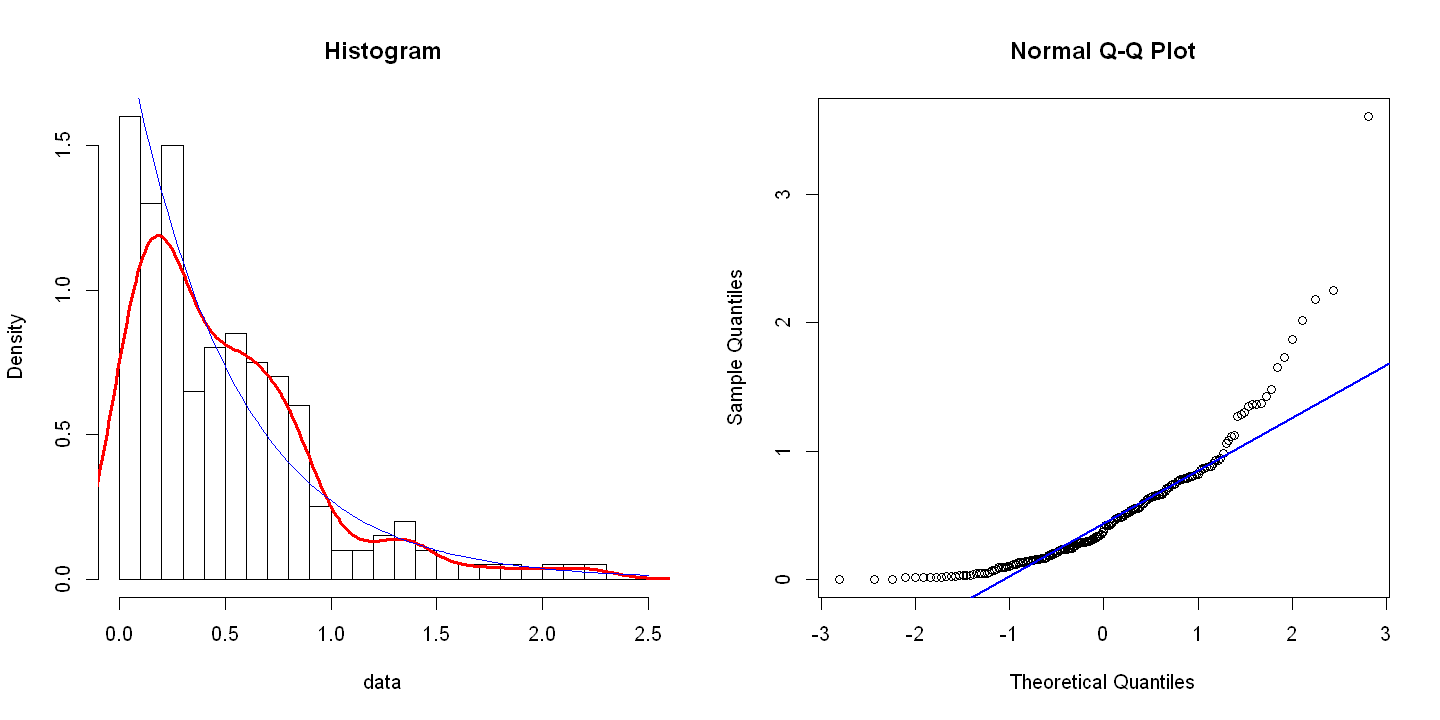

In [9]:
options(repr.plot.width = 12, repr.plot.height = 6)
par(mfcol = c(1,2)) # create a subplot 1x2

# Histogram
hist(data, prob = TRUE, breaks = 50, main = "Histogram", xlim = c(0,2.5))
lines(density(data, kernel = "gaussian"), col = "red", lwd = 3) # kernel density approximation
curve(dexp(x, rate=lambda), col = "blue", lwd = 1, add = TRUE) # theoretical standard normal density

# Q-Q Plot
qqnorm(data) 
qqline(data, col = "blue", lwd = 2, datax = FALSE)


Firstly, a histogram should represent the distribution of our data as frequencies of different ranges of values in our sample. Ideally, if we sampled a data exactly imitating the blue theoretical curve, we could find the population mean estimate simply as a sample mean. Since this is obviously not our case as the red curve suggests, we need to sample many times to get closer to the theoretical distribution.

Secondly, the QQ plot helps us assess whether our data set follows a theoretical exponential distribution representing as a blue curve. Since we can observe some diviation, we cannot estimate the exact population statistics using only one sample. 

The main idea of both of these graphs is that it is not enough to use only one sample with 200 observations for estimation of true population statistics => we need to extend our sample using, e.g., bootstrapping.

#### (d) Use brute force bootstrapping to obtain the Bootstrap mean, standard errors and bias-reduced estimate of the mean. Use 100,000 bootstrap replications.

In [10]:
boot <- 100000
boot_mean <- rep(0, boot)

for (i in 1:boot) {
    boot_data <- sample(data, size=length(data), replace=TRUE)
    boot_mean[i] <- mean(boot_data)
} 
 
# Bias
sprintf("Bootstrap mean: %.6f", mean(boot_mean))
sprintf("Bootstrap s.e. for the mean: %.6f", sd(boot_mean))
sprintf("Bias reduced estimate of mean: %.6f",2 * sample_mean - mean(boot_mean))

[1] "Bootstrap mean: 0.503570"

[1] "Bootstrap s.e. for the mean: 0.033993"

[1] "Bias reduced estimate of mean: 0.503664"

We applied the bootstrap algorith for 100000 repetitions manually in this section and got an estimate for a population mean 0.5036, which is already quite close. Small standard errors also suggest relative robustness of our result. The interesting observation is that the bootstrapping estimation and an estimation using only one sample are almost the same, suggesting we randomly sampled data relatively close to population values. The main value added of our estimation are probably the standard erros instead of having only point estivation as before that tells a lot about possible distinction on a true value. 

#### (e) Now, use the ’boot’ function with 100,000 bootstrap replications.

In [8]:
# Define function calculating mean of a sample subset by indexes idx
boot_statistic <- function(data, idx) {
    mean = mean(data[idx])
    return(mean)
}


bootstrap_result <- boot(data, statistic=boot_statistic, R = boot)
print(bootstrap_result)


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = data, statistic = boot_statistic, R = boot)


Bootstrap Statistics :
     original       bias    std. error
t1* 0.5036166 0.0001448822  0.03403546


In this sections, we only replicated the bootstrap algorith from the previous part using the boot function. As the results are almost identical, it confirms the technical correctness of our results. 

#### (f) Obtain the confidence intervals, use different types and compare the results. Which type is appropriate to use in this case?

In [10]:
boot.ci(bootstrap_result, conf=0.95, type=c("norm", "basic", "perc", "bca"))


BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 100000 bootstrap replicates

CALL : 
boot.ci(boot.out = bootstrap_result, conf = 0.95, type = c("norm", 
    "basic", "perc", "bca"))

Intervals : 
Level      Normal              Basic         
95%   ( 0.4368,  0.5702 )   ( 0.4346,  0.5677 )  

Level     Percentile            BCa          
95%   ( 0.4395,  0.5727 )   ( 0.4440,  0.5789 )  
Calculations and Intervals on Original Scale

We suggest to use the BCa confidence intervals since it indicates greater precision and less uncertainty in our results. The normal type assumes normal distribution data which we clearly do not have, basic type performs better on not-skewed distributions. On the other hand, percentile type is more precise and robust for skewed distributions as the exponential one is. However, we consider type BCA being the best option since it incorporates bias correction that we found above and acceleration being also suitable for skewed distributions.  

#### (g) Plot the bootstrapped mean. Discuss.

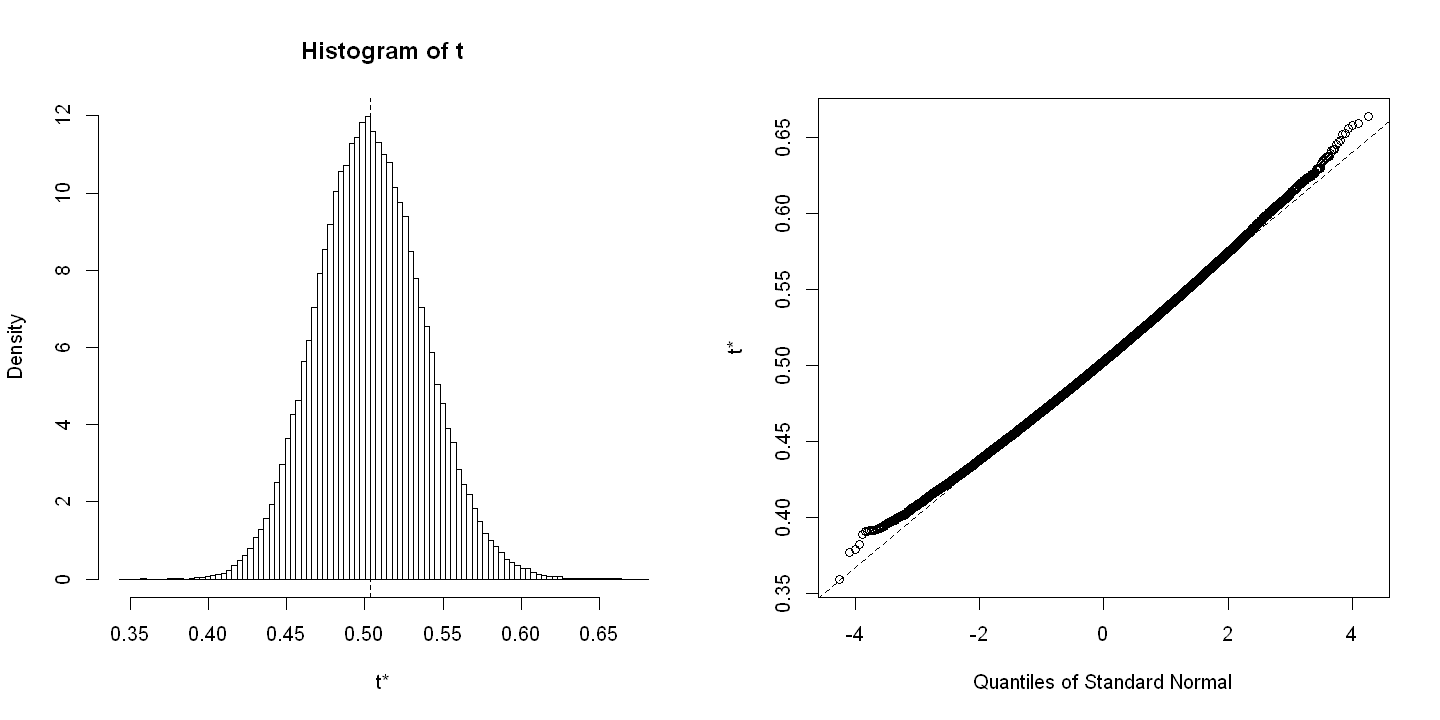

In [11]:
plot(bootstrap_result)

The histogram reveals the idea behind whole bootstrap algorith. Applying the law of large numbers, the higher number of repetitions we use for bootstrapping, the closer we get to the true population mean and the more robust are estimate will be. Moreover, the line in our second graph represents a population mean suggesting that more of our sample means were relatively close. In conclution, the bootstrap computation was not computionally demanding so that we could further extend number of data points, number of repetitions or sampling smaller samples for higher accuracy of our results.

# Problem 4: Endogeneity

#### Data generating process

In [1]:
# load necessary libraries
library(gmm)
library(systemfit)
library(AER)

Warning message:
"package 'gmm' was built under R version 3.6.3"Loading required package: sandwich
Loading required package: Matrix
Loading required package: car
Loading required package: carData
Loading required package: lmtest
Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Please cite the 'systemfit' package as:
Arne Henningsen and Jeff D. Hamann (2007). systemfit: A Package for Estimating Systems of Simultaneous Equations in R. Journal of Statistical Software 23(4), 1-40. http://www.jstatsoft.org/v23/i04/.

If you have questions, suggestions, or comments regarding the 'systemfit' package, please use a forum or 'tracker' at systemfit's R-Forge site:
https://r-forge.r-project.org/projects/systemfit/
Loading required package: survival


In [2]:
# generate data
#number of observations
n <- 250

#set seed for replication of the results
set.seed(155) 

# create z
z1 <-rnorm(n, 3, 9)
z2 <-rnorm(n, 2, 0.5*0.5)
z3 <-rnorm(n, 0, 4)
z4 <-rnorm(n, 2.8, 0.2*0.2)


# create erorrs
e1 <- rnorm(n, 0, 1.2*1.2)
e2 <- rnorm(n, 0, 1.2*1.2)
e3 <- rnorm(n, 0, 1.2*1.2)

# create x1, x2 and x3
x1 <- 0.8*z1 + 2*z2 - 3*z4 + 0.5*e1

x2 <- 0.75*z2 - z4 + 0.5*e2

x3 <- rnorm(n, 0, 1)

# create the dependent variable
y <- 1 + 2*x1 - 0.5*x2 + 2.5*x3 + e3

In [3]:
# create dataframe with all variables
data <- data.frame(y,x1,x2,x3,z1,z2,z3,z4,e1,e2,e3)
data_x <- data.frame(x1, x2, x3)

#create correlation matrix 
cor(data_x)

,x1,x2,x3
x1,1.00000000,0.01402747,-0.01715505
x2,0.01402747,1.00000000,0.09912384
x3,-0.01715505,0.09912384,1.00000000


### (a)

We can expect endogeneity in the model, because variable x2 is ommitted from the estimated model and its effect is observed in the eror term. The reason why it causes endogeneity is that x1 and x2 may be correlated. It is because both contain independent varaiables z2 and z4 in their equations. Correlation matrix shows that the correlation is very low. As the correlation is positive and effect of x2 is negative, we expect downward bias of β1 in OLS. 
We suggest to use test for endogeneity and use instrumental variable.

### (b)

In [4]:
# model estimated with OLS
model_OLS <- lm(y ~ x1 + x3)
summary(model_OLS)


Call:
lm(formula = y ~ x1 + x3)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.9515 -1.0177  0.0161  0.8810  5.6366 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.74996    0.09844   17.78   <2e-16 ***
x1           1.99216    0.01321  150.78   <2e-16 ***
x3           2.36952    0.09377   25.27   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.498 on 247 degrees of freedom
Multiple R-squared:  0.9895,	Adjusted R-squared:  0.9894 
F-statistic: 1.162e+04 on 2 and 247 DF,  p-value: < 2.2e-16


Model estimated by OLS leads to estimates of β1 and β3 that are statistically significant. Moreover, the coefficients are relatively close to correct coefficients that are in the data generating process. The only exception is intercept, that is different from its correct value of 1.

### (c)

In [5]:
# check relevance of instruments
instruments1 <- lm(x1 ~ z1, data = data)
summary(instruments1)

instruments4 <- lm(x1 ~ z1 + z2 + z3 + z4, data = data)
summary(instruments4)
 
anova(instruments1,instruments4)


Call:
lm(formula = x1 ~ z1, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.84521 -0.52627  0.05116  0.53078  2.07466 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -4.31652    0.05222  -82.66   <2e-16 ***
z1           0.80325    0.00560  143.45   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.7857 on 248 degrees of freedom
Multiple R-squared:  0.9881,	Adjusted R-squared:  0.988 
F-statistic: 2.058e+04 on 1 and 248 DF,  p-value: < 2.2e-16



Call:
lm(formula = x1 ~ z1 + z2 + z3 + z4, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.23684 -0.43642 -0.00014  0.46014  1.84144 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -4.277488   3.034664  -1.410    0.160    
z1           0.806907   0.004891 164.992   <2e-16 ***
z2           1.723637   0.190799   9.034   <2e-16 ***
z3          -0.011037   0.011054  -0.998    0.319    
z4          -1.256338   1.084541  -1.158    0.248    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.6819 on 245 degrees of freedom
Multiple R-squared:  0.9911,	Adjusted R-squared:  0.991 
F-statistic:  6851 on 4 and 245 DF,  p-value: < 2.2e-16


Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
248,153.0876,NA,NA,NA,NA
245,113.9088,3,39.17881,28.08915,1.202389e-15


In [6]:
# check relevance of z3
instruments3 <- lm(x1 ~ z1 + z2 + z4, data = data)
summary(instruments3)

instruments4 <- lm(x1 ~ z1 + z2 + z3 + z4, data = data)
summary(instruments4)
 
anova(instruments3,instruments4)


Call:
lm(formula = x1 ~ z1 + z2 + z4, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.22906 -0.44284 -0.01179  0.43959  1.80252 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -4.054428   3.026409  -1.340    0.182    
z1           0.807169   0.004884 165.284   <2e-16 ***
z2           1.733946   0.190519   9.101   <2e-16 ***
z4          -1.342828   1.081069  -1.242    0.215    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.6819 on 246 degrees of freedom
Multiple R-squared:  0.9911,	Adjusted R-squared:  0.991 
F-statistic:  9135 on 3 and 246 DF,  p-value: < 2.2e-16



Call:
lm(formula = x1 ~ z1 + z2 + z3 + z4, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.23684 -0.43642 -0.00014  0.46014  1.84144 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -4.277488   3.034664  -1.410    0.160    
z1           0.806907   0.004891 164.992   <2e-16 ***
z2           1.723637   0.190799   9.034   <2e-16 ***
z3          -0.011037   0.011054  -0.998    0.319    
z4          -1.256338   1.084541  -1.158    0.248    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.6819 on 245 degrees of freedom
Multiple R-squared:  0.9911,	Adjusted R-squared:  0.991 
F-statistic:  6851 on 4 and 245 DF,  p-value: < 2.2e-16


Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
246,114.3723,NA,NA,NA,NA
245,113.9088,1,0.4634569,0.9968229,0.3190656


We will calculate also correlations.

In [7]:
# Correlation between IVs z1, z2,... and x1
data_z <- data.frame(z1, z2, z3, z4)
cor(data_z,data$x1)

z1,0.99402800
z2,-0.02644400
z3,-0.05404251
z4,0.04733485


In [8]:
# create composed error from x2 and e3 (it would not be possible in actual data, that are not artificially generated)
e <- -0.5*x2 + e3
data$e <- e

In [9]:
# check correlation between z1, z2,... and composed error
cor(data_z,data$e)

z1,-0.028592784
z2,-0.010938522
z3,0.027912891
z4,-0.006271599


To be a good instuments a variable must be uncorrelated with error term  ϵ, which consists of - 0.5*x2 and e3. Second, it should be correlated with x1. Theoretically, from the data generating process we know, that z2 and z4 are correlated with x1, but they are also correlated with x2. Thus they do not satisfy necessary conditions. Only z1 satisfies both conditions.

When testing the relevance of the potential instrumental varaibles, we found that z1,z2 and z4 are relevant. Only z3 is irrelevant.

Calculated correlations shows that correlation between z1 and x1 is strong. So, it is a good instrument. Correlation between error term - 0.5*x2 + e3 and z2, z4 is low, which is reason why they should not be invalid. Also correlation between x1 and z2 and z4 is low. Therefore the two are rather weak instruments.

### (d)

In [10]:
# model estimated with IV
model_IV <- ivreg(y ~ x1 + x3 | x3 + z1, data = data)
summary(model_IV)


Call:
ivreg(formula = y ~ x1 + x3 | x3 + z1, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-4.94205 -1.01994  0.01425  0.87593  5.62444 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.75309    0.09849   17.80   <2e-16 ***
x1           1.99371    0.01329  149.99   <2e-16 ***
x3           2.36971    0.09377   25.27   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.498 on 247 degrees of freedom
Multiple R-Squared: 0.9895,	Adjusted R-squared: 0.9894 
Wald test: 1.151e+04 on 2 and 247 DF,  p-value: < 2.2e-16 


In [11]:
# model estimated with 2SLS
model_2SLS = tsls(y ~ x1 + x3, ~ x3 + z1 + z2 + z4, data = data)
summary(model_2SLS)


Call:
tsls(g = y ~ x1 + x3, x = ~x3 + z1 + z2 + z4, data = data)


Method:  Two Stage Least Squares(Meat type = Classical) 

Coefficients:
             Estimate     Std. Error   t value      Pr(>|t|)   
(Intercept)   1.7530e+00   9.8477e-02   1.7801e+01   6.9882e-71
x1            1.9936e+00   1.3272e-02   1.5021e+02   0.0000e+00
x3            2.3697e+00   9.3770e-02   2.5271e+01  6.5747e-141

J-Test: degrees of freedom is 2 
                J-test     P-value  
Test E(g)=0:    0.0090764  0.9954721


 First stage F-statistics: 
x1 : F( 4 ,  245 ) =  6840.047  (P-Vavue =  0 )

The coefficient estimates and standard errors of the two models are very close. The results are only negligible.

### (e)

In [21]:
# Hausman test
model_ols <- systemfit(y ~ x1 + x3, data = data, method = "OLS")

model_iv <- systemfit(y ~ x1 + x3, data = data, method = "2SLS", inst = ~ x3 + z1 + z2 + z4)

hausman.systemfit(model_iv, model_ols)


	Hausman specification test for consistency of the 3SLS estimation

data:  data
Hausman = 1.3949, df = 3, p-value = 0.7067


Results of Hausman test containing p value much above 0.1 indicate that we cannot reject null hypothesis that both estimators (OLS and IV) are consistent. Thus, we cannot confirm that endogeneity is present.

### (f)

In [13]:
# larger dataset
# number of observations
nE <- 100000

#set seed for replication of the results
set.seed(153) 

# create z
z1E <-rnorm(nE, 3, 9)
z2E <-rnorm(nE, 2, 0.5*0.5)
z3E <-rnorm(nE, 0, 4)
z4E <-rnorm(nE, 2.8, 0.2*0.2)


# create erorrs
e1E <- rnorm(nE, 0, 1.2*1.2)
e2E <- rnorm(nE, 0, 1.2*1.2)
e3E <- rnorm(nE, 0, 1.2*1.2)

# create x1, x2 and x3
x1E <- 0.8*z1E + 2*z2E - 3*z4E+ 0.5*e1E

x2E <- 0.75*z2E - z4E + 0.5*e2E

x3E <- rnorm(nE, 0, 1)

# create the dependent variable
yE <- 1 + 2*x1E - 0.5*x2E + 2.5*x3E + e3E

In [14]:
# create dataframe with all variables
dataE <- data.frame(yE,x1E,x2E,x3E,z1E,z2E,z3E,z4E,e1E,e2E,e3E)

In [15]:
# model estimated with OLS
model_OLS_E <- lm(yE ~ x1E + x3E, data = dataE)
summary(model_OLS_E)


Call:
lm(formula = yE ~ x1E + x3E, data = dataE)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.6787 -0.9953 -0.0003  1.0003  7.1941 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1.6539836  0.0048670   339.8   <2e-16 ***
x1E         1.9988284  0.0006458  3094.9   <2e-16 ***
x3E         2.4940887  0.0046939   531.3   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.484 on 99997 degrees of freedom
Multiple R-squared:   0.99,	Adjusted R-squared:   0.99 
F-statistic: 4.929e+06 on 2 and 99997 DF,  p-value: < 2.2e-16


In [16]:
# model estimated with IV
model_IV_E <- ivreg(yE ~ x1E + x3E |  z1E + x3E, data = dataE)
summary(model_IV_E)


Call:
ivreg(formula = yE ~ x1E + x3E | z1E + x3E, data = dataE)

Residuals:
      Min        1Q    Median        3Q       Max 
-6.670014 -0.994101 -0.001127  1.000271  7.200861 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1.6560090  0.0048696   340.1   <2e-16 ***
x1E         1.9998446  0.0006507  3073.4   <2e-16 ***
x3E         2.4940944  0.0046939   531.3   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.484 on 99997 degrees of freedom
Multiple R-Squared:  0.99,	Adjusted R-squared:  0.99 
Wald test: 4.863e+06 on 2 and 99997 DF,  p-value: < 2.2e-16 


In [17]:
# model estimated with 2SLS
model_2SLS_E = tsls(yE ~ x1E + x3E, ~ x3E + z1E + z2E + z4E, data = dataE)
summary(model_2SLS_E)


Call:
tsls(g = yE ~ x1E + x3E, x = ~x3E + z1E + z2E + z4E, data = dataE)


Method:  Two Stage Least Squares(Meat type = Classical) 

Coefficients:
             Estimate    Std. Error  t value     Pr(>|t|)  
(Intercept)  1.6541e+00  4.8687e-03  3.3974e+02  0.0000e+00
x1E          1.9989e+00  6.4906e-04  3.0797e+03  0.0000e+00
x3E          2.4941e+00  4.6939e-03  5.3135e+02  0.0000e+00

J-Test: degrees of freedom is 2 
                J-test      P-value   
Test E(g)=0:    4.2375e+02  9.6475e-93


 First stage F-statistics: 
x1E : F( 4 ,  99995 ) =  2507268  (P-Vavue =  0 )

In [24]:
# Hausman test
model_ols_E <- systemfit(yE ~ x1E + x3E, data = dataE, method = "OLS")
model__E <- systemfit(yE ~ x1E + x3E, data = dataE, method = "2SLS", inst = ~ x3E +  z1E + z2E + z4E)

print(hausman.systemfit(model_iv_E, model_ols_E))


	Hausman specification test for consistency of the 3SLS estimation

data:  dataE
Hausman = 164.55, df = 3, p-value < 2.2e-16



Estimates for the second dataset show significantly lower p-value than for the first dataset. For any reasonable significance level we can reject null hypothesis that both estimators (OLS and 2SLS) are consistent. It implies that only 2SLS provides consistent estimates and endogeneity is present.